
No duplicate entries found.
Missing values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


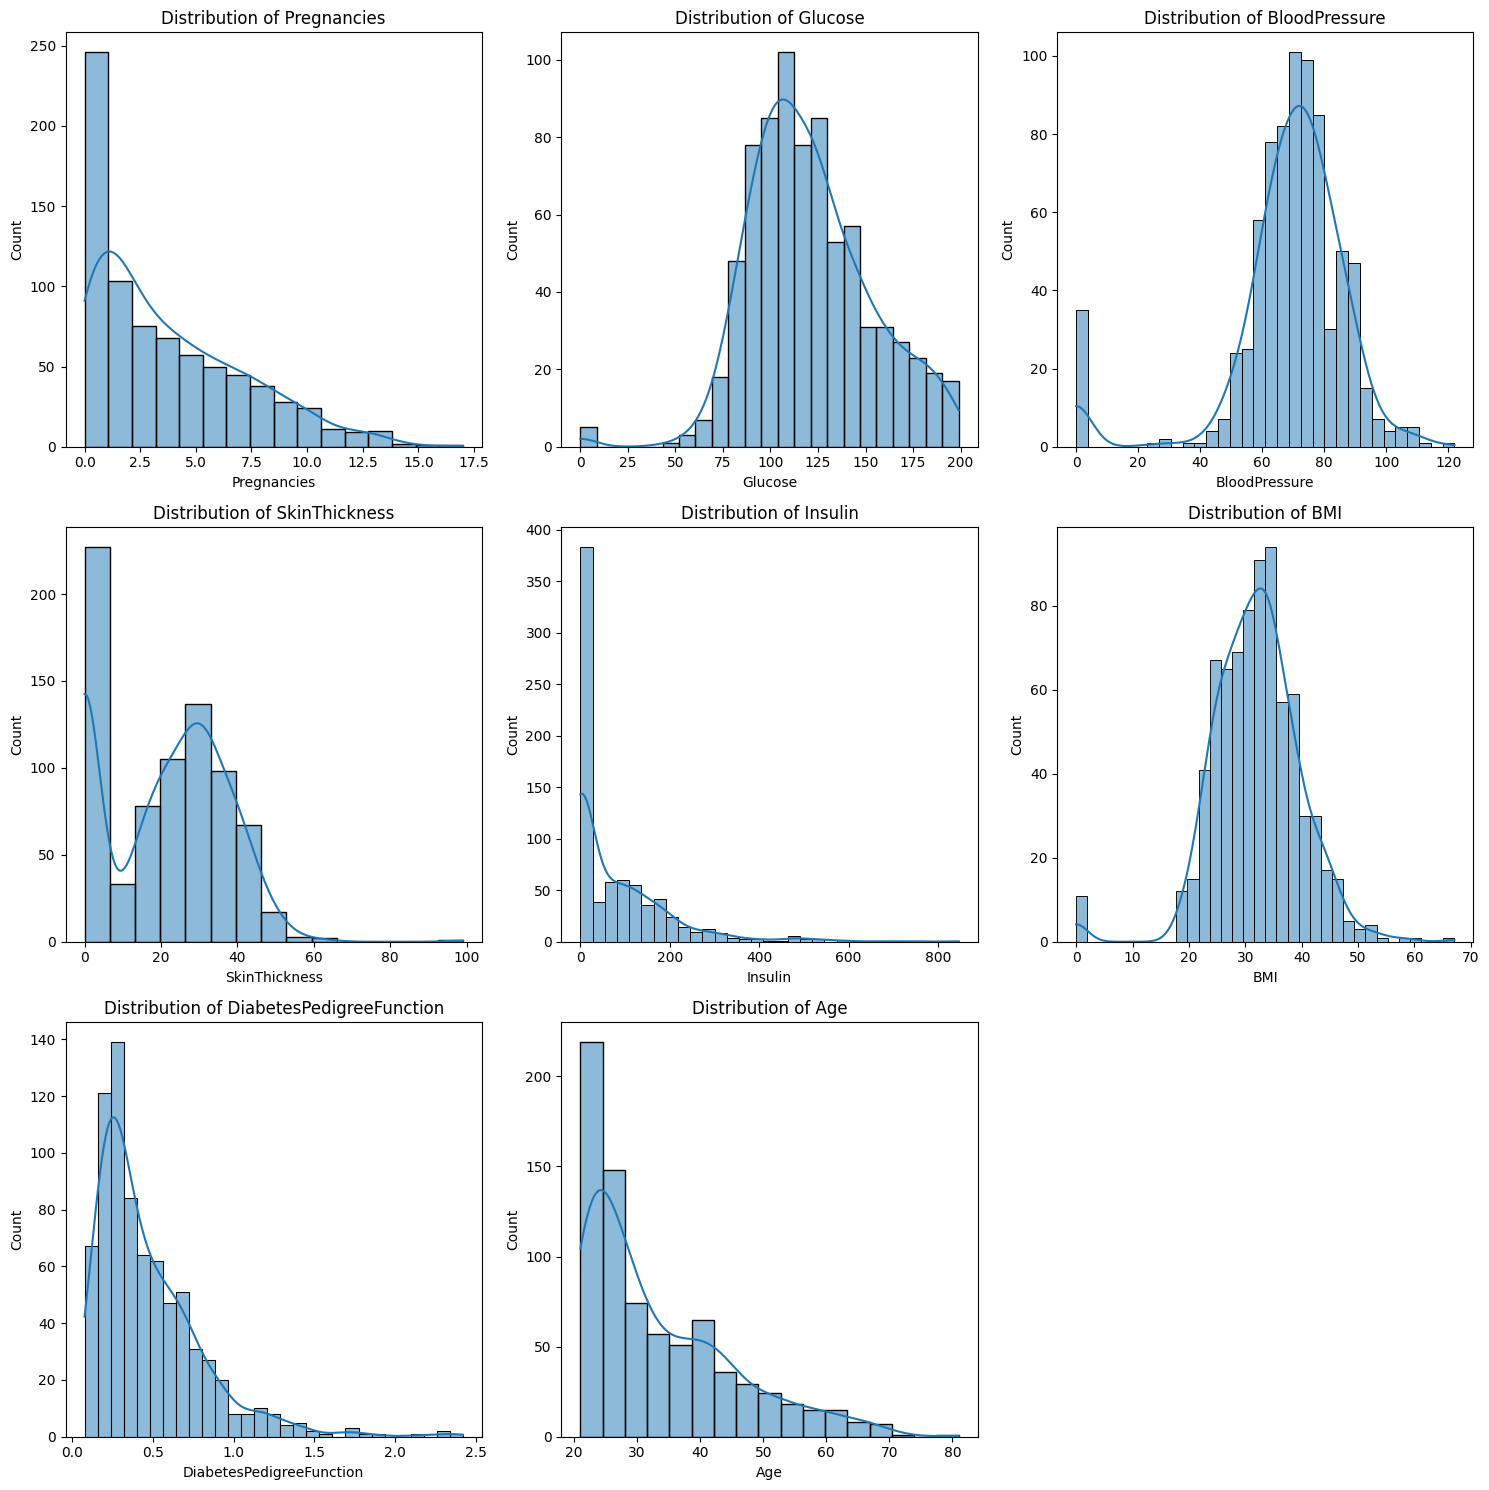

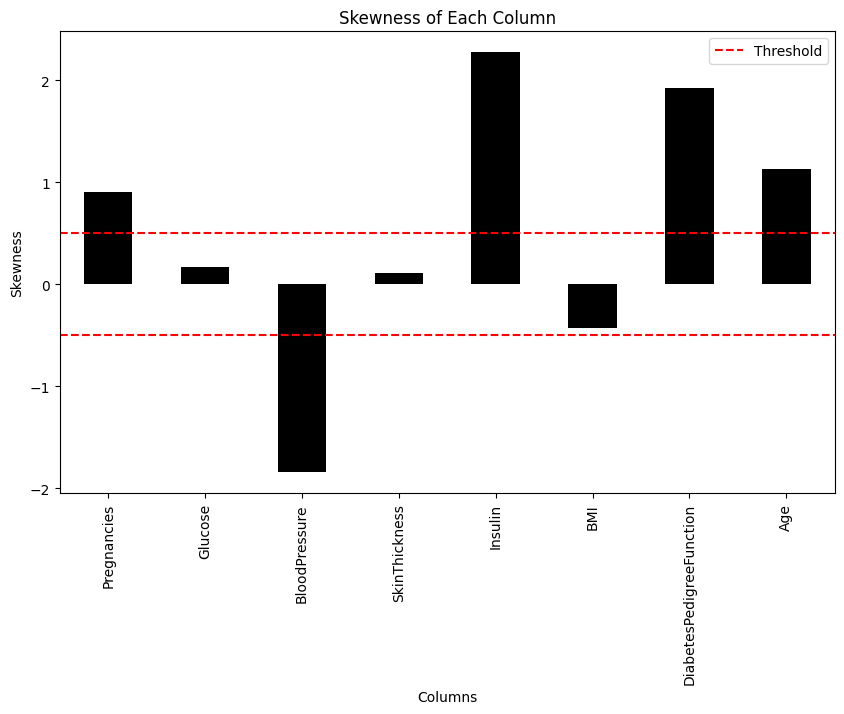

Columns with significant skewness (absolute skewness > 0.5):
Pregnancies                 0.901674
BloodPressure              -1.843608
Insulin                     2.272251
DiabetesPedigreeFunction    1.919911
Age                         1.129597
dtype: float64


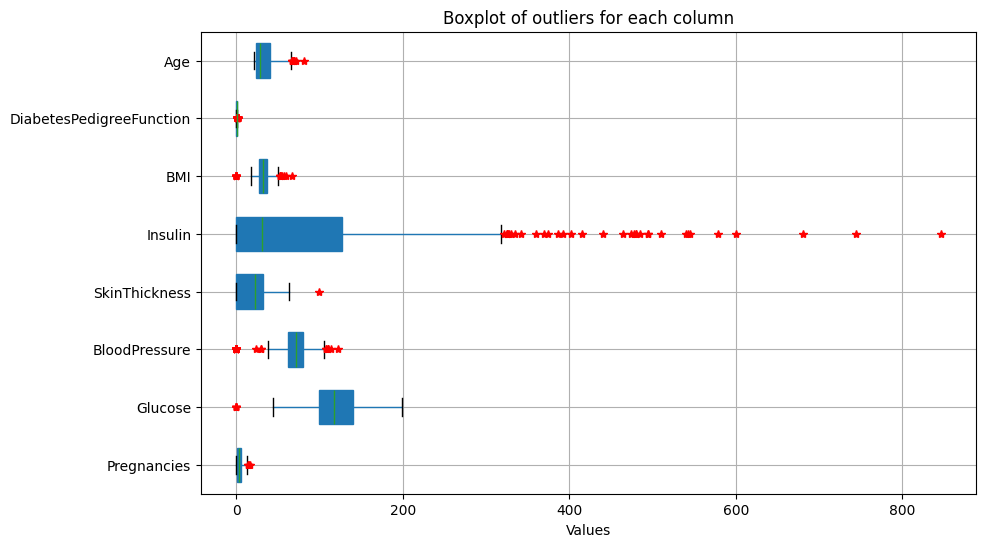

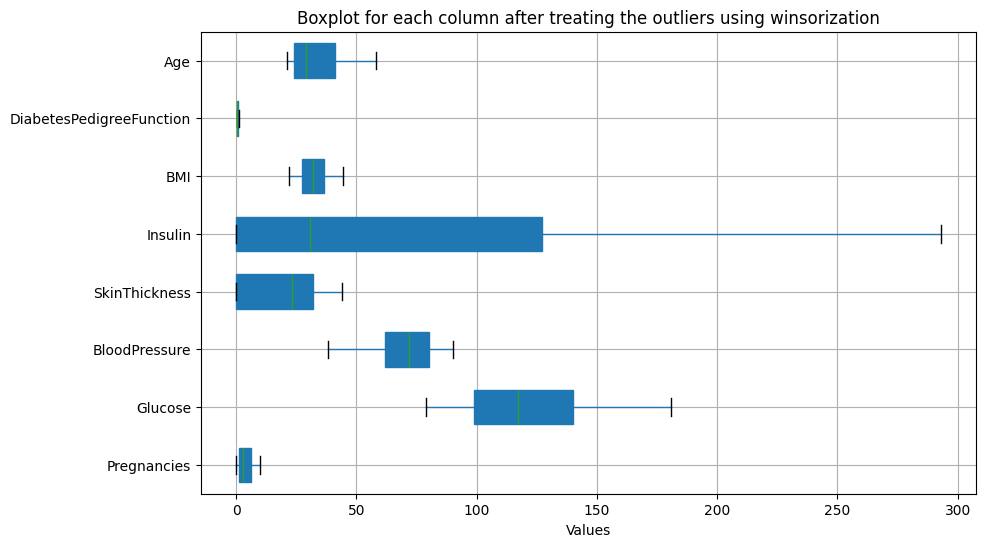

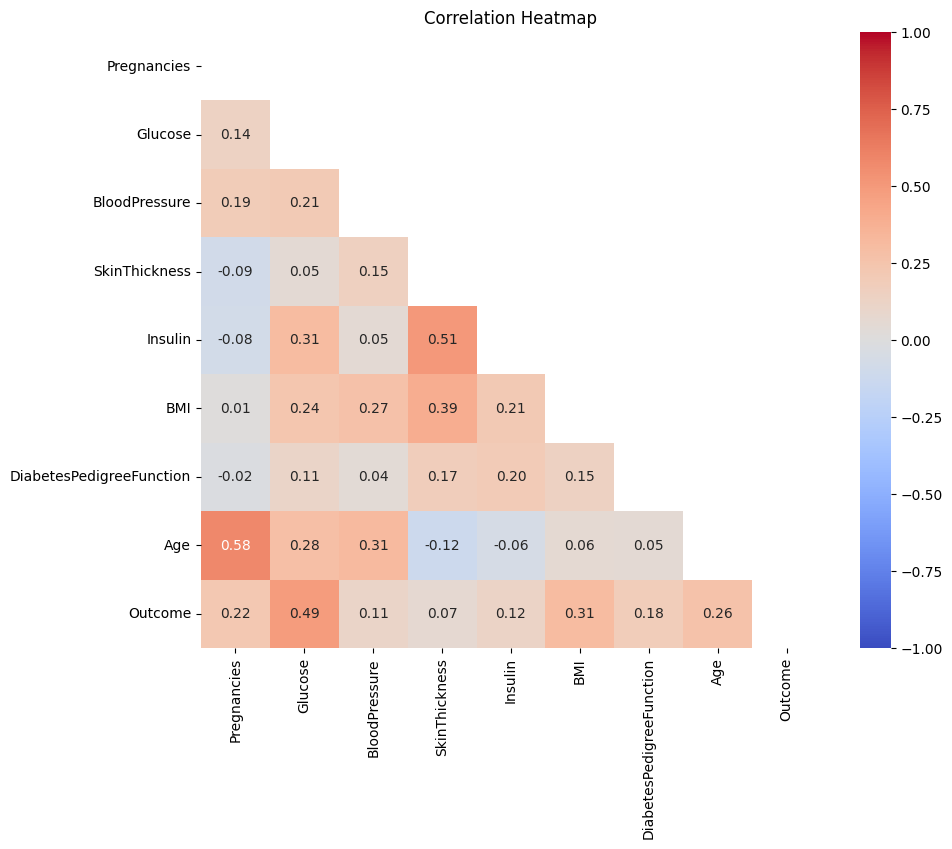

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from prettytable import PrettyTable

# read training data
df= pd.read_csv('./input/diabetes.csv')

df
df.dtypes
# Check for duplicate entries
duplicate_rows = df[df.duplicated()]
duplicate_rows
print("\nNo duplicate entries found.")

# Check for missing or null values
missing_values = df.isnull().sum()
# Display the count of missing values for each column
print("Missing values in each column:")
print(missing_values)

# Describe the data
df.describe().transpose()


# ///// Check the normal distribution of each feature //////
# Define the features to visualize
features_to_plot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Set up the subplots in a grid
num_cols = len(features_to_plot)
num_rows = int(np.ceil(num_cols / 3))  
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop through each feature and plot the distribution
for i, feature in enumerate(features_to_plot):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# ////////Detect skewness////////////////
# set the threshold
threshold = 0.5  

# Extract input columns (excluding the last column)
input_columns = df.columns[:-1].tolist()

# Calculate skewness for each column
skewness = df[input_columns].skew()

# Identify columns with skewness exceeding the threshold
skewed_columns = skewness[abs(skewness) > threshold]

# Plot the skewness values
plt.figure(figsize=(10, 6))
skewness.plot(kind='bar', color='black', alpha=1)
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='red', linestyle='--')
plt.title('Skewness of Each Column')
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.legend()
plt.show()

# Display the skewed columns
print("Columns with significant skewness (absolute skewness > {}):".format(threshold))
print(skewed_columns)

# ////// Check for outliers /////////
input_columns = df.columns[:-1].tolist()
# Create a boxplot for each column excluding the last one
plt.figure(figsize=(10, 6))
df[input_columns].boxplot(sym='r*', vert=False, patch_artist=True, widths=0.6)
plt.title('Boxplot of outliers for each column')
plt.xlabel('Values')
plt.show()

# //////  Winsorization:  ////////////
# Apply winsorization to address extreme values and enhance model robustness.

input_columns = df.columns[:-1].tolist()
# Function to replace outliers with winsorized values
def winsorize_outliers(column):
    # Winsorize the column, capping extreme values
    winsorized_values = winsorize(column, limits=[0.05, 0.05])
    return winsorized_values
# Apply the function to each column in the DataFrame
for column in input_columns:
    df[column] = winsorize_outliers(df[column])

input_columns = df.columns[:-1].tolist()

# Create a boxplot for each column excluding the last one
plt.figure(figsize=(10, 6))
df[input_columns].boxplot(sym='r*', vert=False, patch_artist=True, widths=0.6)
plt.title('Boxplot for each column after treating the outliers using winsorization')
plt.xlabel('Values')
plt.show()

# //////////  Check for correlation between variables in the dataset ////////
correlation_matrix = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()
# A significant positive correlation (>0.5) exists between age and pregnancies, as well as between insulin and skin thickness. 
# To address multicollinearity, one option is to exclude one of these variables.

# /////// Explore the target variable, Outcome ////////////////
sns.countplot(x='Outcome', data=df, label='Count')
plt.show()
print("\nNumber of non-diabetic cases (labeled as 0)")
print((df.Outcome == 0).sum())
print("\nNumber of diabetic cases (labeled as 1):")
print((df.Outcome == 1).sum())

# //////   Define X and y  /////////////
#Pregnancies and SkinThickness were excluded because of their correlation with Age and Insulin, respectively. 
#Age and Insulin appear to be crucial factors in relation to diabetes.
X = df.drop(['Outcome', 'Pregnancies', 'SkinThickness'], axis=1)
y = df['Outcome']


# ////////  Construct the ML model using Support Vector Machine //////////
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an SVC model
svc_model = SVC(kernel='linear', C=0.01, gamma='scale')

# Train the model on the training set
svc_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = svc_model.predict(X_train)

# Make predictions on the test set
y_test_pred = svc_model.predict(X_test)

# Calculate metrics for training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, svc_model.decision_function(X_train))

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, svc_model.decision_function(X_test))

# Create a PrettyTable
table = PrettyTable()
table.field_names = ["Metric", "Training Set", "Test Set"]
table.add_row(["Accuracy", f"{train_accuracy*100:.2f}%", f"{test_accuracy*100:.2f}%"])
table.add_row(["Precision", f"{train_precision:.2f}", f"{test_precision:.2f}"])
table.add_row(["Recall", f"{train_recall:.2f}", f"{test_recall:.2f}"])
table.add_row(["F1 Score", f"{train_f1:.2f}", f"{test_f1:.2f}"])
table.add_row(["AUC", f"{train_auc:.2f}", f"{test_auc:.2f}"])

# Print the table
print(table)


